# Developing a State-of-the-Art Interpreter Model for Sign Language Communication
Contributors: Shubham Khandale, Allen Lau, Sumaiya Uddin

Source Code: https://github.com/DataScienceAndEngineering/machine-learning-dse-i210-final-project-signlanguageclassification.git

Project Workspace Setup: Run /src/data/make_dataset.py to download necessary data to execute this notebook.

Table of Contents:
1. [Abstract](#abstract)
2. [Introduction](#introduction)
3. [Background](#background)
4. [Data](#data)
5. [Methods](#methods)
6. [Evaluation](#evaluation)
7. [Conclusion](#conclusion)
8. [Attribution](#attribution)
9. [Bibliography](#bibliography)
10. [Appendix](#appendix)


Libraries

In [19]:
#importing libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib.colors import ListedColormap

import pickle
import cv2

#from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Abstract <a class="anchor" id="abstract"></a>

Clear and effective communication is a vital component of society. However, for individuals who rely on sign language, interacting with those who are unfamiliar with this mode of communication can be a difficult task. The development of a model capable of receiving a video stream from a camera and accurately classifying the signed letters can prove to be an invaluable tool. This technology can be utilized in various settings, including hospitals, schools, and government offices, to facilitate seamless communication and eliminate any potential communication barriers.

This notebook outlines the process of identifying the best models and features to accurately and quickly classify hand signs in a live setting, where the chosen models are divided into non-deep learning and deep learning approaches. The best non-deep learning approach is identified as a Stacking Ensemble Classifier, consisting of Logistic Regression, Support Vector Machine, Random Forest, and XGBoost estimators and a Logistic Regression meta-estimator. The features to train this ensemble model are the 23 components resulted from Linear Discriminant Analysis on the images' 784 pixel feature arrays and the first 30 principal components of the derived histogram of oriented gradients features. The best deep learning approach is identified as a convolutional neural network trained on 224 x 224 images with hand landmarks plotted onto the images. 

## Introduction <a class="anchor" id="introduction"></a>

## Background <a class="anchor" id="background"></a>

## Data <a class="anchor" id="data"></a>

The Sign Language MNIST dataset ([Kaggle](https://www.kaggle.com/datasets/datamunge/sign-language-mnist))  will be used for developing the Sign Language Interpreter model. It is structured as a CSV format with rows containing flattened images of pixel intensity values and its associated letter label. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z, which require motion and will not be explored in this project). The training data (27,455 instances) and test data (7172 cases) are around half the size of the standard MNIST but otherwise identical, with a header row of label, pixel1, pixel2,...pixel784 representing a single 28x28 pixel image with grayscale values ranging from 0-255.

In [113]:
#function for loading the sign language mnist dataset pickle file, generated from /src/data/make_dataset.py
def load_sign_minist(path):
    #load defined pickle file and return dat 
    with open(path,'rb') as f:
        data = pickle.load(f)
    return data

#Function to return a dictionary of numeric labels to letters 
def get_label_dict(y):
    #letters
    letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
    #numbers 
    y = pd.Series(y,dtype=int)
    numbers = sorted(list(y.unique()))
    #dictionary of labels 
    return dict(zip(numbers,letters))

#function to find the indices given a label 
def find_indices(data,label):
    #check if data is numpy array
    if type(data) == np.ndarray:
        #return indices
        return np.where(data==label)
    #check if data is pandas series 
    elif type(data) == pd.Series:
        #return indices
        return data[data==label].index
    #else not supported in this function
    else:
        raise Exception('Not supported data type for this function.')
    
#load dataset
X_train,y_train,X_test,y_test = load_sign_minist('../data/external/sign_mnist.pkl')

#get labels dictionary
label_dict = get_label_dict(y_train)

#list of letters
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']

        

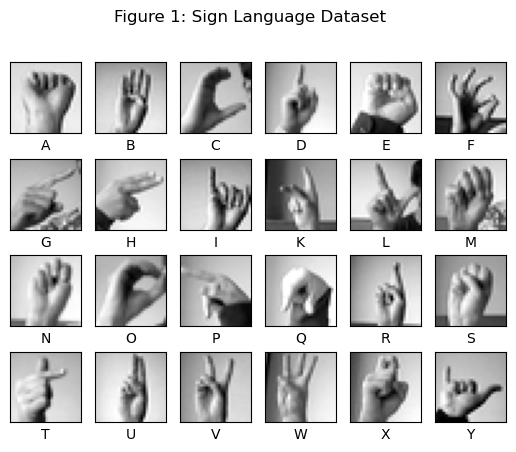

In [33]:
def visualize_data(x,y,labels_dict):
    #visualization of dataset 
    fig, ax = plt.subplots(4,6)
    ax = ax.ravel()
    pos = 0 
    #loop through each label in dataset 
    for label in range(0,26):
        #if label is not included in dataset 
        if label in [9,25]:
            continue
        #find first index of label
        idx = find_indices(y,label)[0][0]
        #display first found image 
        ax[pos].imshow(x[idx],cmap='gray')
        #set x label as dataset label
        ax[pos].set(xlabel=labels_dict[label])
        #do not show ticks 
        ax[pos].set_xticks([])
        ax[pos].set_yticks([])
        #increment for subplotting 
        pos+=1
    plt.suptitle('Figure 1: Sign Language Dataset')
    plt.close()
    return fig

#visualizing examples from the data set
fig = visualize_data(X_train,y_train,label_dict)
fig

Fig. 1 displays example images for each letter in the dataset. As described above, it is observed that each image is a grayscale, 28x28 image. The labels for this classification problem includes letters A - Z, excluding J and Z since these signs are motioned. The images consist of 784 pixel intensity values ranging from 0 - 255, where 0 is black and 255 is white, which are the features being used for machine learning. 

The letters A, E, M, N, and S are similar. It is expected that models may have difficulty differentiating these signs. In contrast, letters like L, O, and Y are very different from the other classes; therefore, it is expected that the models would perform better classifying these letters. 

### Exploratory Data Analysis

The average image, created by taking the average values of each pixel across all images in the dataset, is plotted below. Additionally, the variance image, created by taking the variance of values for each pixel across all images, is plotted. 

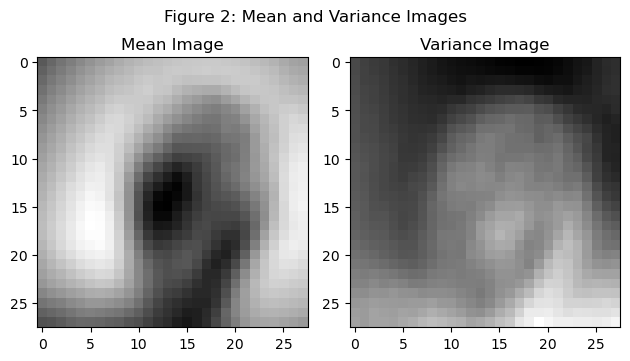

In [34]:
def mean_var_image(x):
    #create subplot
    fig, ax = plt.subplots(1, 2)
    ax = ax.ravel()
    #reshaping arrays and finding the mean and variance of each picel 
    x = x.reshape(x.shape[0], -1)
    mean_img = np.mean(x, axis=0)
    var_img = np.var(x, axis=0)
    #plotting mean image
    ax[0].imshow(mean_img.reshape(28, 28), cmap='gray')
    ax[0].set_title('Mean Image')
    #plotting variance image
    ax[1].imshow(var_img.reshape(28, 28), cmap='gray')
    ax[1].set_title('Variance Image')
    
    plt.suptitle('Figure 2: Mean and Variance Images',y=0.85)
    plt.tight_layout()
    plt.close()
    return fig

#Plotting mean and varience image
mean_var_image(X_train)

Figure 2 displays the Mean Image, which illustrates the average positioning of our hands being centered with there being a small border on all sides. The background is generally white, however there are some differences in the far corners of the images. The Variance Image shows that the background of our images are not consistently the same. 

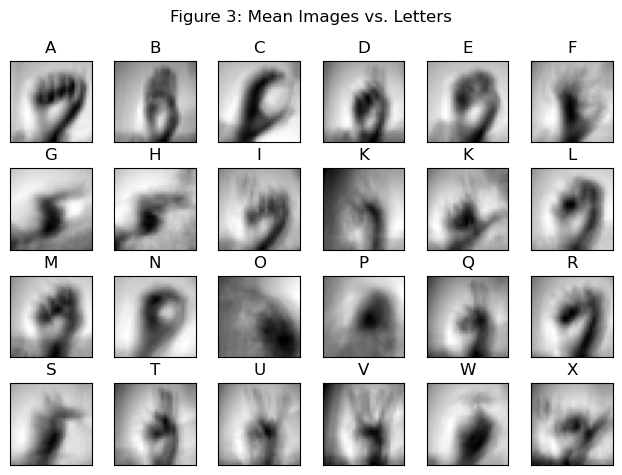

In [66]:
#Function to plot the average and variance images for each class in a dataset.
def plot_mean_images(X, y, label_dict):
    # Grouping the training data by label and calculate the mean of each pixel across all observations with the same label
    mean_images = []
    for label in np.unique(y):
        label_images = X[y == label]
        mean_image = np.mean(label_images, axis=0)
        mean_images.append(mean_image)

    # Plotting the average image for each class
    fig, ax = plt.subplots(4, 6)
    ax = ax.ravel()
    pos = 0
    for i, mean_image in enumerate(mean_images):
        if i == 9:
            i+=1
        ax[pos].imshow(mean_image, cmap='gray')
        label = label_dict[i]  # Retrieve the corresponding letter using the label index
        ax[pos].set_title(label)
        ax[pos].set_xticks([])
        ax[pos].set_yticks([])
        pos+=1

    plt.suptitle('Figure 3: Mean Images vs. Letters')
    plt.tight_layout()
    plt.show()

# Create the label dictionary
label_dict = get_label_dict(y_train)

# Call the function to plot the mean images
plot_mean_images(X_train, y_train, label_dict)

Figure 3 illustrates the mean image for each letter, showing the average hand positions for each class. Letters that have extended fingers are more blurry around the fingers, showing that there is more variability in the finger positions. In contrast, letters like A and E do not have extended fingers and show less variability (blurriness). It is expected that letters with less variability may be show more overfit results, since they are more similar. 

Next, the total counts of the individual labels are plotted to determine if there are any class imbalances that need to be addressed before modeling. The following code is used to plot Figure 4, which displays the distribution of train and test labels in the dataset. This plot illustrates that there are no class-imbalances within the dataset, so there is no need to rebalance classes or sample. 

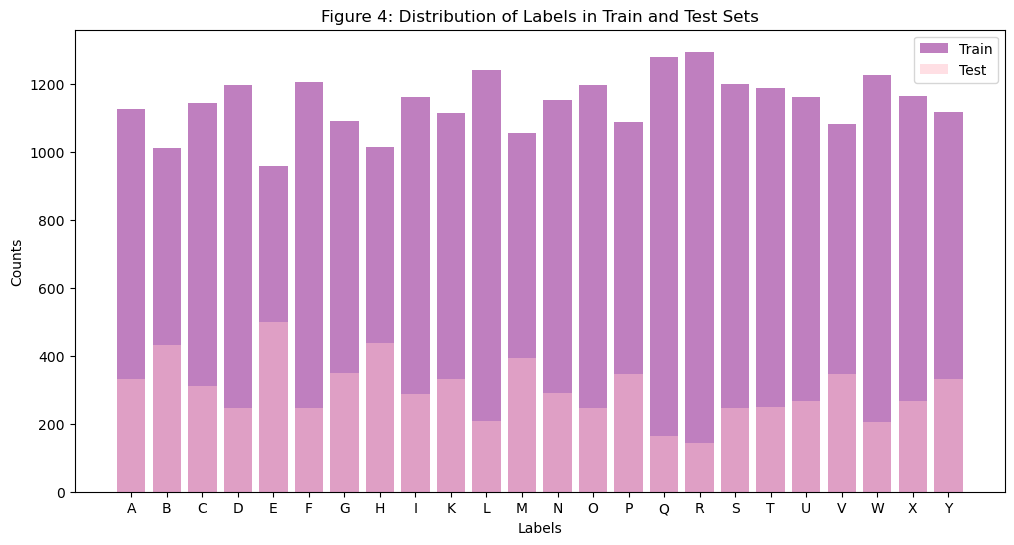

In [93]:
#function for getting label distribution
def label_distr(X_train,y_train,X_test,y_test):
    train=pd.concat([pd.DataFrame(X_train.reshape(X_train.shape[0],-1)),pd.DataFrame(y_train,columns=['label'])],axis=1)
    test=pd.concat([pd.DataFrame(X_test.reshape(X_test.shape[0],-1)),pd.DataFrame(y_test,columns=['label'])],axis=1)
    fig, ax = plt.subplots(figsize=(12, 6))

    # Grouping the train and test sets by label and count the number of observations for each label
    train_counts = train.groupby('label').size()
    test_counts = test.groupby('label').size()

    # Custom colors
    train_color = 'purple'
    test_color = 'pink'

    # Plotting the bar chart for train & test set
    letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
    ax.bar(letters, train_counts, color=train_color, alpha=0.5, label='Train')
    ax.bar(letters, test_counts, color=test_color, alpha=0.5, label='Test')

    # Adding legend and labels
    ax.legend()
    ax.set_xlabel('Labels')
    ax.set_ylabel('Counts')
    ax.set_title('Figure 4: Distribution of Labels in Train and Test Sets')

    plt.show()

label_distr(X_train,y_train,X_test,y_test)

The histograms of pixel intensities are plotted below in Figure 4. It is observed that the majority of the label distributions are unimodal, left-skewed distributions. This indicates that the majority of the images have more white (or brighter) pixels than black (or darker) pixels. Additionally, most distributions have a spike of frequency at 255, which is due to the fact that most of the backgrounds in the dataset are white. 

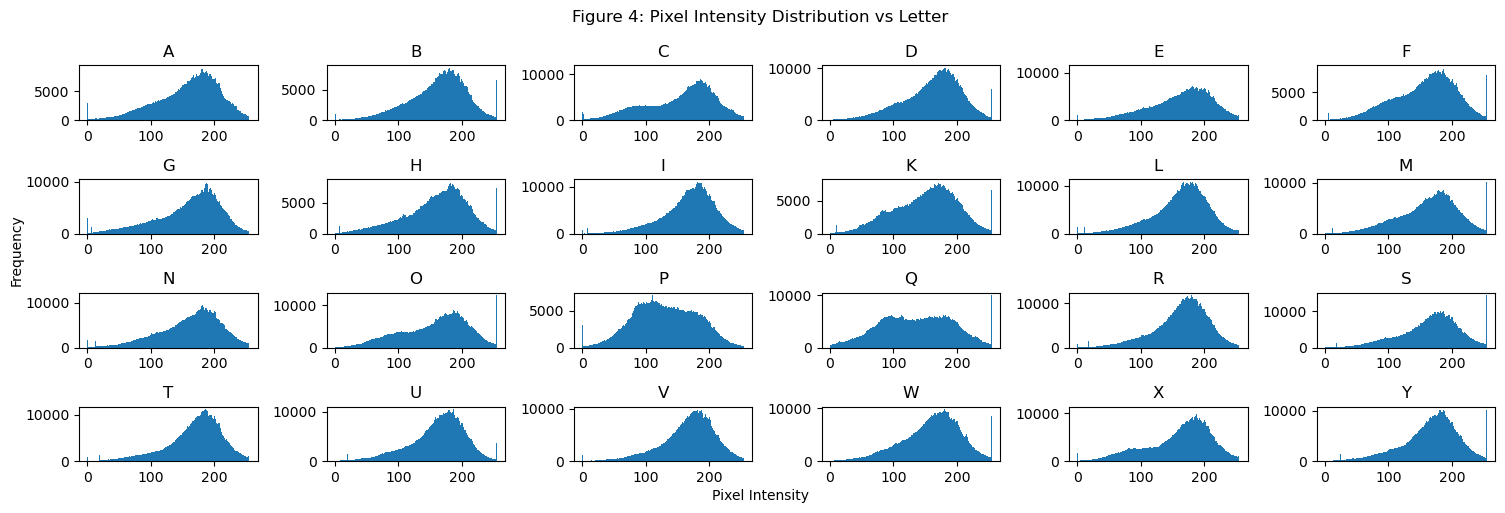

In [112]:
def label_histograms(X,y,label_dict):
    #creating dataframe for data 
    data=pd.concat([pd.DataFrame(X.reshape(X.shape[0],-1)),pd.DataFrame(y.astype(int),columns=['label'])],axis=1)
    #finding unique labels
    unique_labels = sorted(data['label'].unique())  # Sort the unique labels in ascending order
    #finding length of unique labels
    num_labels = len(unique_labels)

    fig, axes = plt.subplots(4, 6, figsize=(15,5))
    subplot_index = 0
    axes = axes.ravel()
    #plotting histograms 
    for i in unique_labels:
        if i == 9:
            continue

        label_data = data[data['label'] == i]
        pixel_values = label_data.iloc[:, 1:].values
        axes[subplot_index].hist(pixel_values.flatten(), bins=256)
        axes[subplot_index].set_title(label_dict[i])
        subplot_index += 1

    plt.suptitle('Figure 4: Pixel Intensity Distribution vs Letter')
    fig.text(0.5, 0, 'Pixel Intensity', ha='center')
    fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

label_histograms(X_train,y_train,label_dict)

## Methods <a class="anchor" id="methods"></a>

The first step taken to train the sign language classification model is reshaping the train and test images, such that they are flattened arrays of 784 pixels per image. This step is required so that the data can be used in Scikit Learn's data science functionality. The resultant shapes for the data are seen below.

In [115]:
# Reshape the data to (num_samples, 784)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
# Print the shapes of the augmented data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (27455, 784)
y_train shape: (27455,)
X_test shape: (7172, 784)
y_test shape: (7172,)


Second, normalization is performed so that any techniques that are sensitive to the scale of the features are not affected negatively, in terms of bias towards features with high-magnitude scales or ease and speed of convergence. Normalization of the images is performed on both the train and test data by dividing by 255. 

In [116]:
#normalized data 
X_train_norm = X_train/255 
X_test_norm = X_test/255

Using the preprocessed data, initial baseline modeling was performed using Naive Bayes and Logistic Regression. The procedure for initial baseline modeling utilized Randomized Grid Search Cross Validation to identify the hyperparameters that produced the best performing models. All models in this investigation are evaluated using the classification report (depicting accuracy, precision, recall, f1-score, and support), the Matthews correlation coefficient (MCC), and the Kohen Kappa Score, which are computed using the evaluate_model function below.

In [117]:
def evaluate_model(y_true, y_pred, labels):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    
    # Classification report
    print("Classification report:")
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    print(classification_report(y_true, y_pred, target_names=labels))
    
    # Classification report bar graph
    precision = [report[label]['precision'] for label in labels]
    recall = [report[label]['recall'] for label in labels]
    f1_score = [report[label]['f1-score'] for label in labels]

    x = np.arange(len(labels))
    width = 0.3

    # Define custom sequential colormap
    sequence = ['#F7E8F6', '#F1C6E7','#E5B0EA','#BD83CE','#B371C7']
    divergence = ['#f8df81','#f6aa90','#f6b4bf','#dfb6d5','#badfda']
    cmap = ListedColormap(sequence)

    fig, ax = plt.subplots(figsize=(12,8))
    rects1 = ax.bar(x - width, precision, width, label='Precision', color=divergence[2])
    rects2 = ax.bar(x, recall, width, label='Recall', color=divergence[3])
    rects3 = ax.bar(x + width, f1_score, width, label='F1-Score', color=divergence[4])


    ax.set_xlabel('Letters')
    ax.set_ylabel('Score')
    ax.set_title('Classification Report')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.tight_layout()
    plt.show()
    
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"MCC: {mcc}")
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa}")
    
    # Confusion Matrix
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels)
    fig, ax = plt.subplots(figsize=(16,14))  # set figure size
    cm.plot(cmap=cmap, ax=ax)  # set color map and axis
    plt.title("Confusion Matrix")
    plt.show()


# MOVE BASELINE INTO APPENDIX, REFERENCE OVERFIT RESULTS, ADD DETAILS ON HOW WE ADDRESSED OVERFITTING (DATA AUG,DIMENSIONALITY REDUCTION,REGULARIZATION)
# THEN ADD INFO ABOUT THE MAIN ML MODELS INTO THE APPENDIX, REFERENCE THE RESULTS IN A SIMPLIFIED GRAPH SHOWING THE COMPARISION IN PERFROMANCE, ONLY SHOW FINE DETAIL ON BEST PERFORMING MODELS
# BELOW CELLS ARE ONES THAT HAVE NOT BEEN FORMATED OR REVIEWED BY AL 

### Naive bayes

In [152]:
gnb = GaussianNB()
gnb.fit(X_train_norm, y_train)

GaussianNB()

In [153]:
# applying NB on normalized train data
y_pred_train = gnb.predict(X_train_norm)

# applying NB on normalized test data
y_pred_test = gnb.predict(X_test_norm)

Accuracy: 0.4600254962666181
Classification report:
              precision    recall  f1-score   support

           A       0.75      0.47      0.58      1126
           B       0.89      0.47      0.61      1010
           C       0.91      0.76      0.83      1144
           D       0.65      0.44      0.52      1196
           E       0.44      0.67      0.53       957
           F       0.52      0.36      0.42      1204
           G       0.68      0.58      0.63      1090
           H       0.61      0.42      0.50      1013
           I       0.37      0.66      0.48      1162
           K       0.30      0.49      0.37      1114
           L       0.68      0.57      0.62      1241
           M       0.44      0.36      0.39      1055
           N       0.50      0.26      0.34      1151
           O       0.56      0.62      0.59      1196
           P       0.33      0.74      0.45      1088
           Q       0.49      0.54      0.52      1279
           R       0.26      

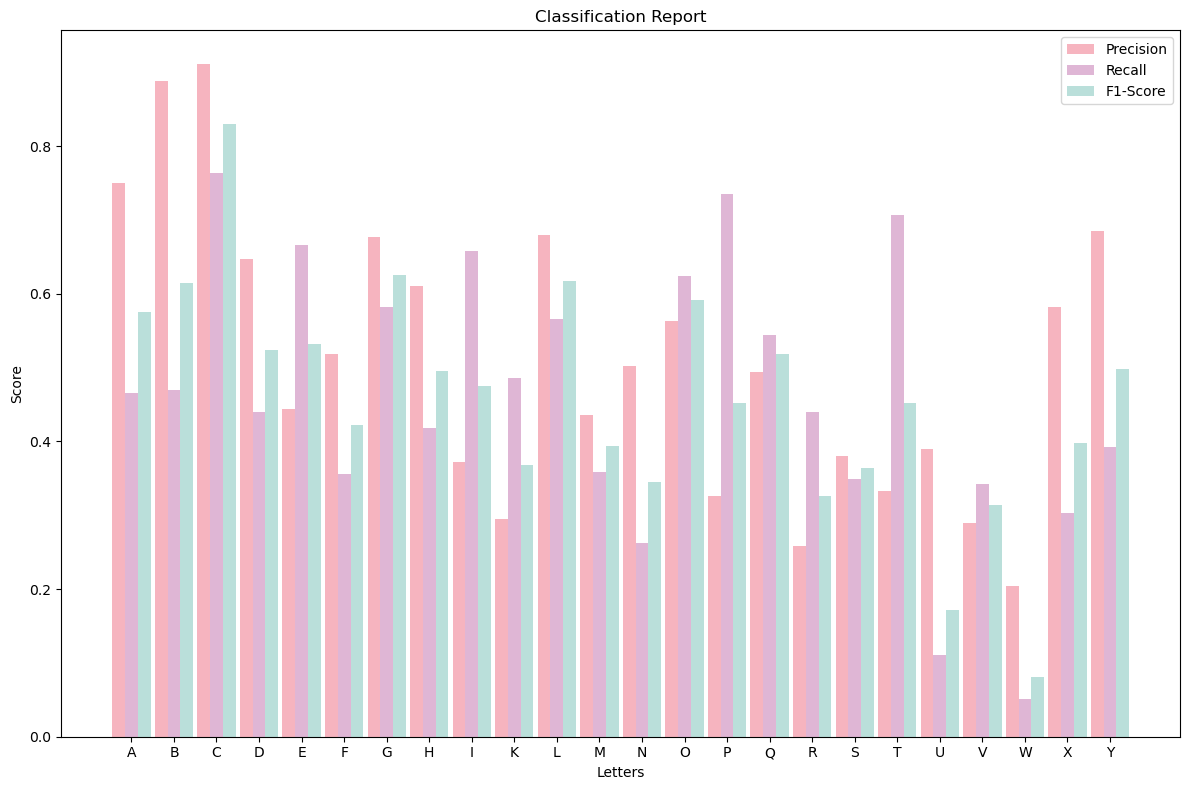

MCC: 0.4392833743318951
Cohen's Kappa: 0.4364137376183579


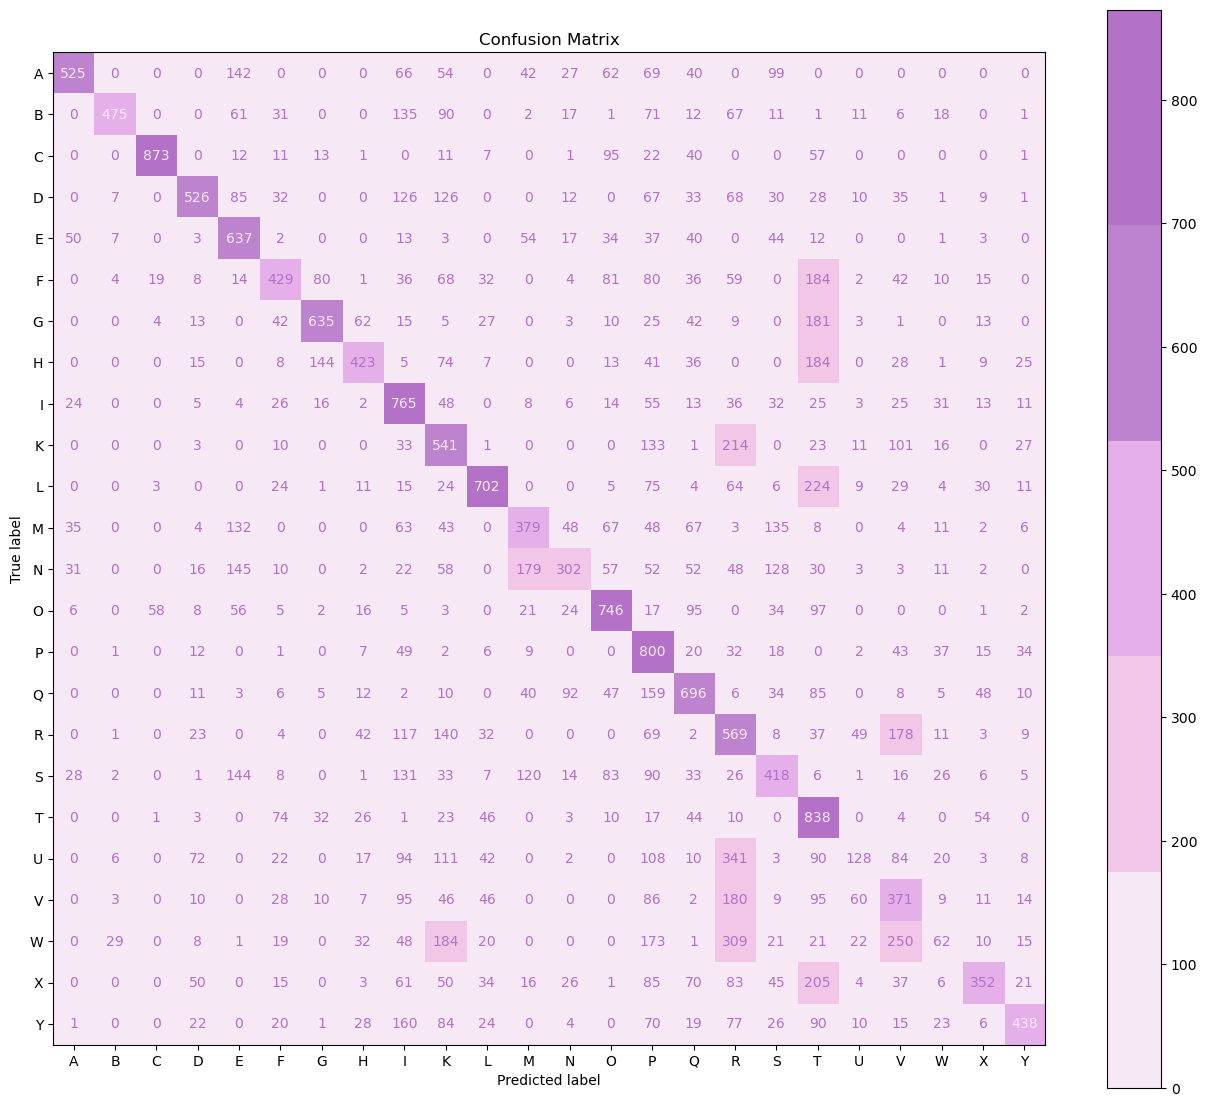

In [185]:
evaluate_model(y_train, y_pred_train, letters)

Accuracy: 0.3898494143892917
Classification report:
              precision    recall  f1-score   support

           A       0.71      0.48      0.57       331
           B       0.96      0.40      0.56       432
           C       0.72      0.50      0.59       310
           D       0.60      0.40      0.48       245
           E       0.53      0.56      0.55       498
           F       0.39      0.26      0.31       247
           G       0.54      0.56      0.55       348
           H       0.85      0.39      0.53       436
           I       0.22      0.45      0.30       288
           K       0.27      0.41      0.33       331
           L       0.41      0.45      0.43       209
           M       0.37      0.19      0.25       394
           N       0.38      0.31      0.34       291
           O       0.37      0.49      0.42       246
           P       0.43      0.81      0.56       347
           Q       0.29      0.60      0.39       164
           R       0.13      

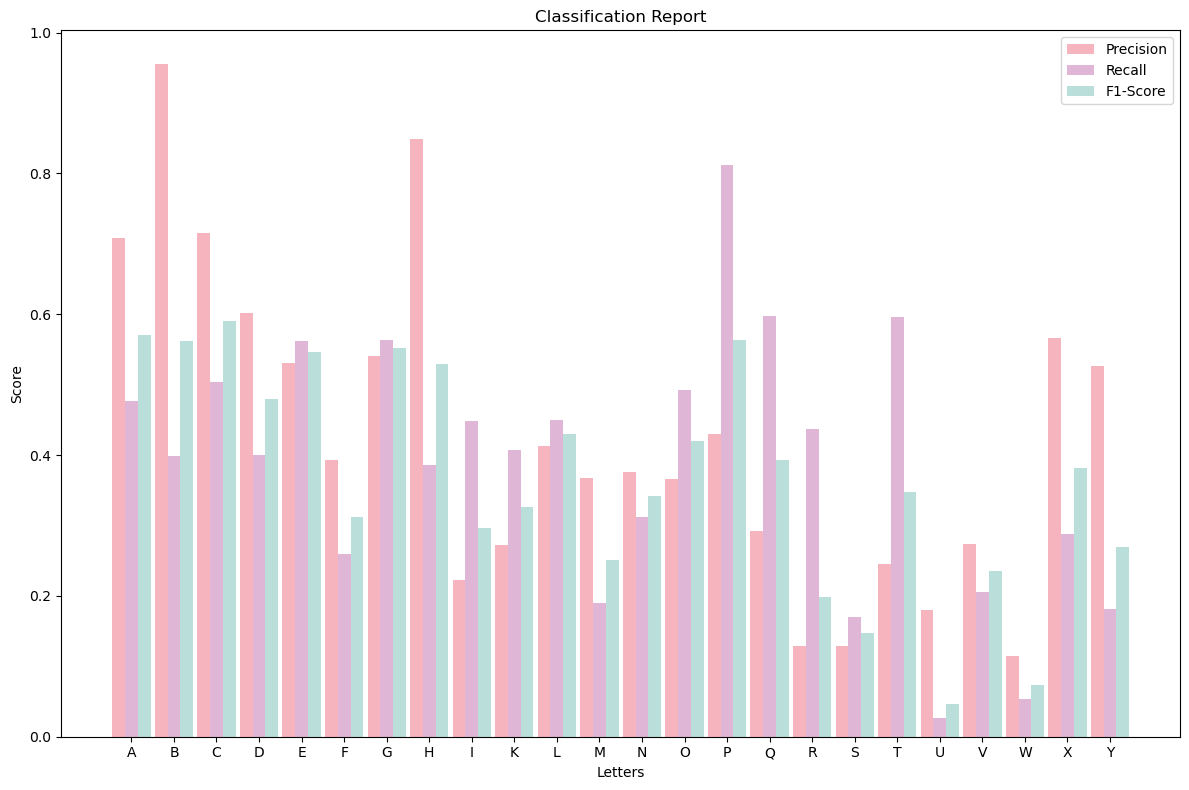

MCC: 0.36615100879087953
Cohen's Kappa: 0.36306888046227415


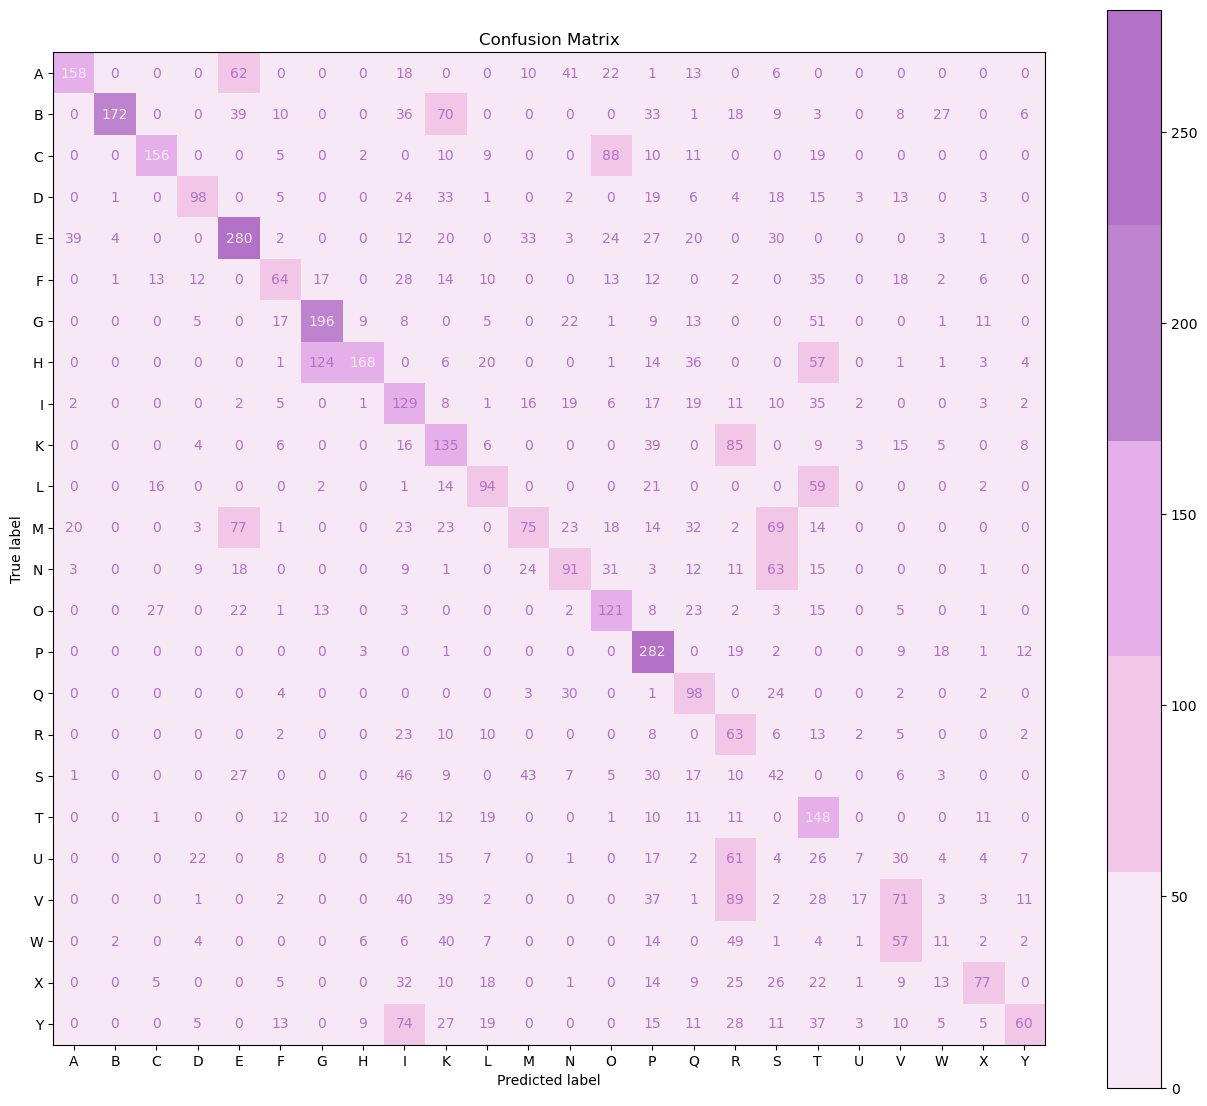

In [186]:
evaluate_model(y_test, y_pred_test, letters)

### Logistic regression

now we will use our best parameters for logistic regression which include regularization on data.

Best hyperparameters: {'C': 3.4647045830997407, 'max_iter': 3171, 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': False}

In [92]:
lr = LogisticRegression(C=3.4647045830997407,
                        max_iter=3171, 
                        penalty="l2", 
                        solver="liblinear",
                        warm_start=False)

lr.fit(X_train_norm, y_train)

LogisticRegression(C=3.4647045830997407, max_iter=3171, solver='liblinear')

In [93]:
# applying Logistic regression on train
y_pred_lr_train = lr.predict(X_train_norm)

# applying Logistic regression on test
y_pred_lr_test = lr.predict(X_test_norm)

Accuracy: 0.999745037333819
Classification report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      1126
           B       1.00      1.00      1.00      1010
           C       1.00      1.00      1.00      1144
           D       1.00      1.00      1.00      1196
           E       1.00      1.00      1.00       957
           F       1.00      1.00      1.00      1204
           G       1.00      1.00      1.00      1090
           H       1.00      1.00      1.00      1013
           I       1.00      1.00      1.00      1162
           K       1.00      1.00      1.00      1114
           L       1.00      1.00      1.00      1241
           M       1.00      1.00      1.00      1055
           N       1.00      1.00      1.00      1151
           O       1.00      1.00      1.00      1196
           P       1.00      1.00      1.00      1088
           Q       1.00      1.00      1.00      1279
           R       1.00      1

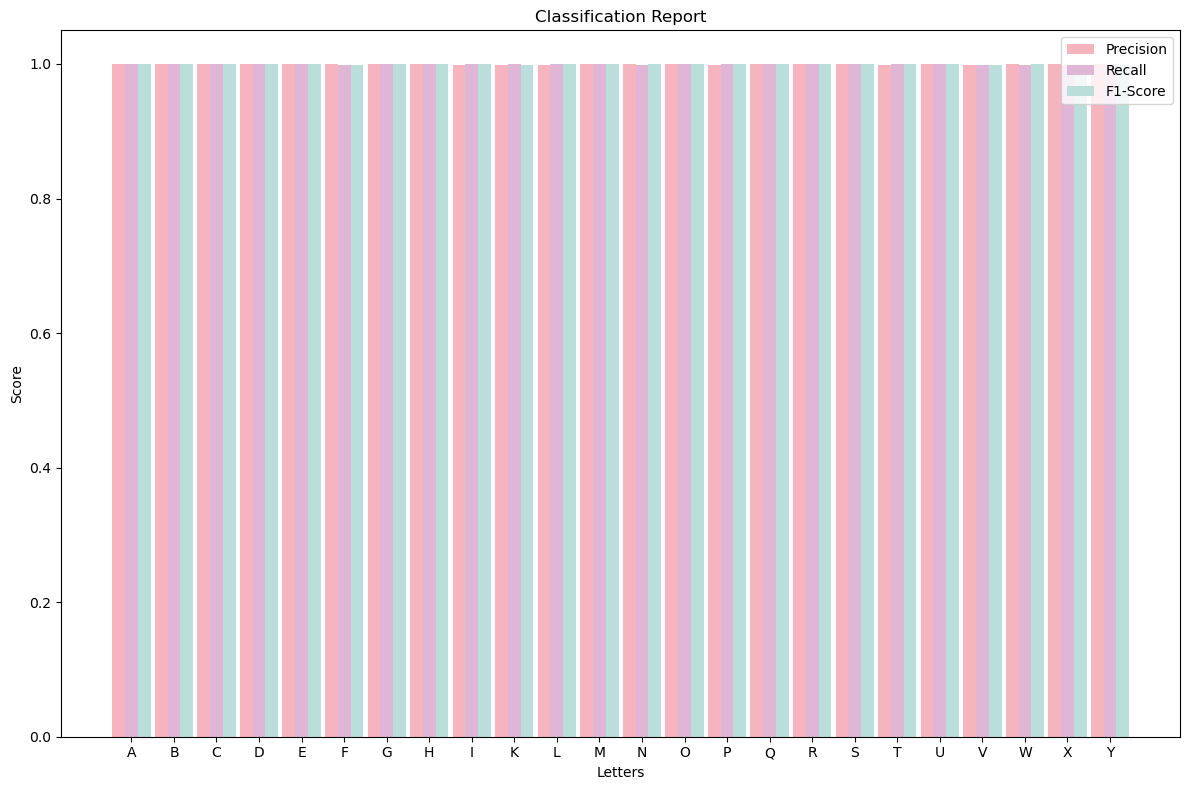

MCC: 0.9997339050943962
Cohen's Kappa: 0.9997338926358993


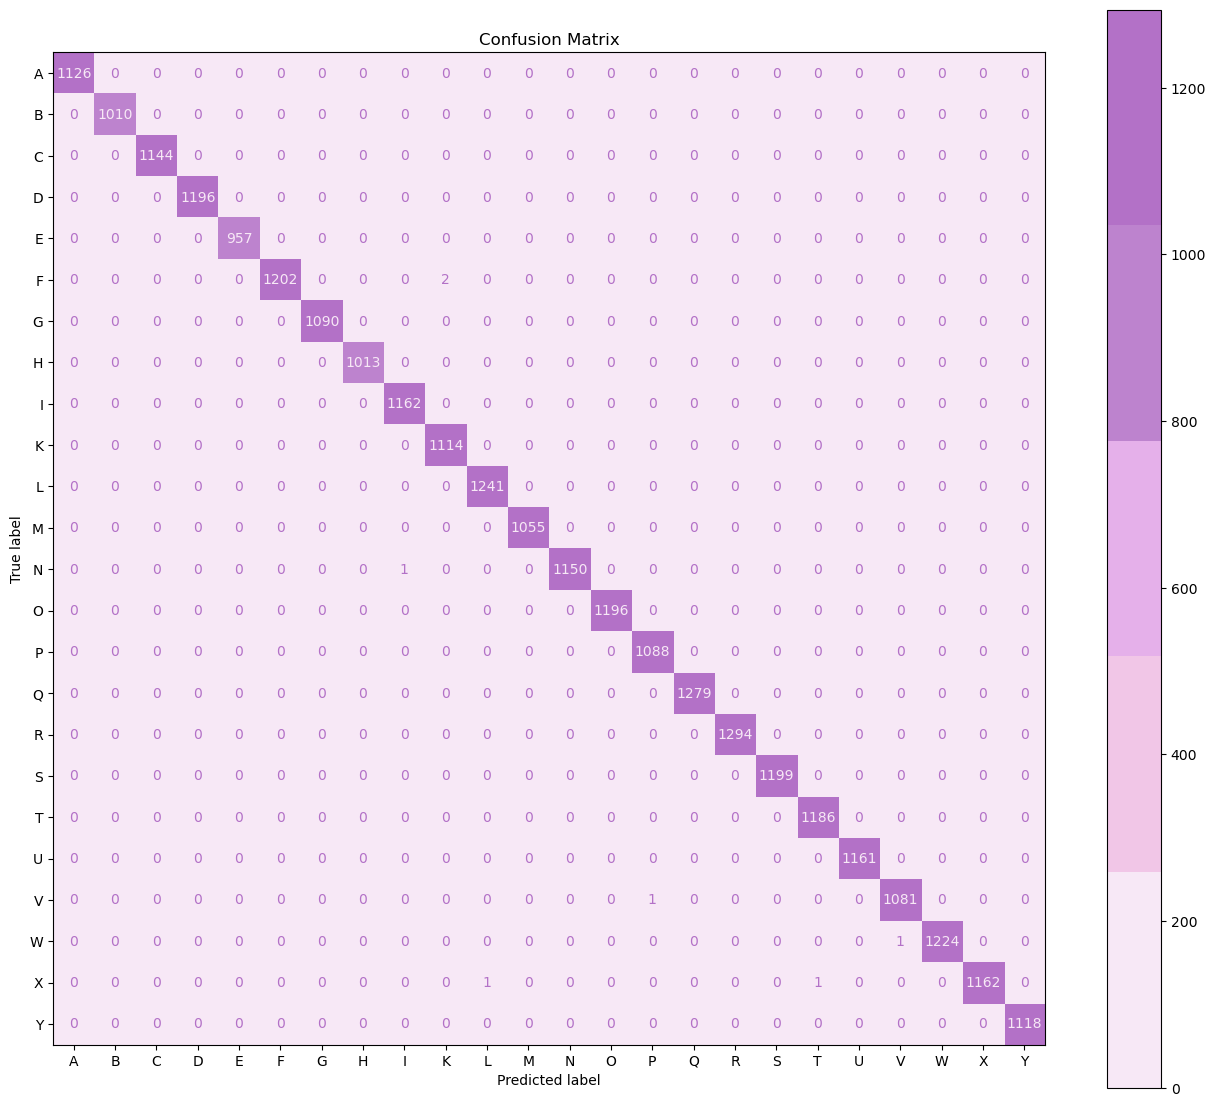

In [187]:
evaluate_model(y_train, y_pred_lr_train, letters)

Accuracy: 0.6692693809258227
Classification report:
              precision    recall  f1-score   support

           A       0.83      0.94      0.89       331
           B       1.00      0.83      0.90       432
           C       0.93      0.86      0.89       310
           D       0.79      0.90      0.84       245
           E       0.80      0.88      0.84       498
           F       0.63      0.90      0.74       247
           G       0.72      0.81      0.76       348
           H       0.84      0.71      0.77       436
           I       0.71      0.57      0.63       288
           K       0.63      0.37      0.46       331
           L       0.78      0.90      0.84       209
           M       0.69      0.49      0.58       394
           N       0.57      0.44      0.50       291
           O       1.00      0.59      0.74       246
           P       0.79      0.79      0.79       347
           Q       0.58      0.74      0.65       164
           R       0.19      

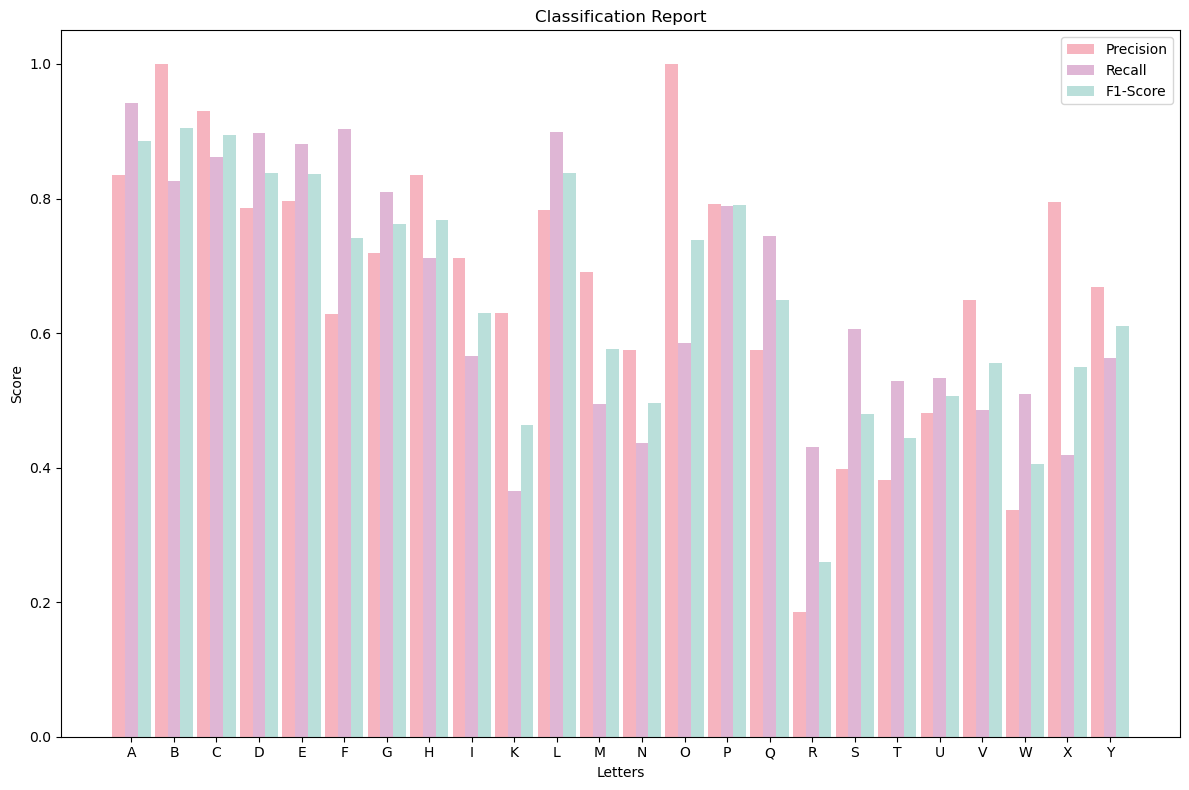

MCC: 0.6555084229826728
Cohen's Kappa: 0.6542843992274351


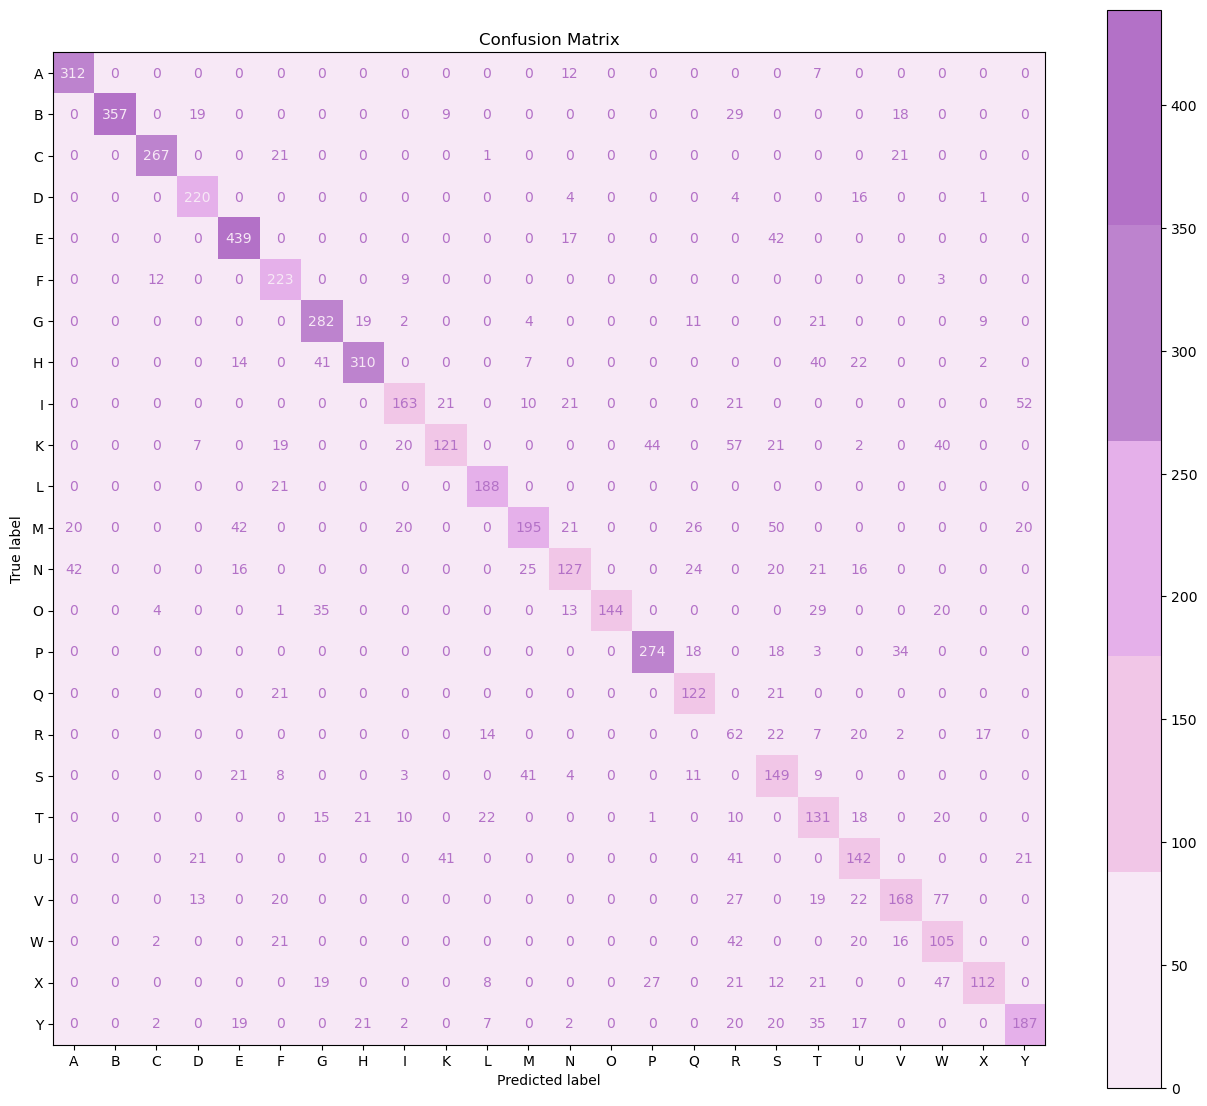

In [188]:
evaluate_model(y_test, y_pred_lr_test, letters)

## Evaluation <a class="anchor" id="evaluation"></a>

## Attribution <a class="anchor" id="attribution"></a>

## Bibliography <a class="anchor" id="bibliography"></a>

## Appendix <a class="anchor" id="appendix"></a>

Feature Selection
* UMAP, SVD, TSNE

Main Model Results not with combined features